In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os

In [21]:
# Set fixed seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42) 

In [22]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'filtered_data.csv')

# Drop any unnamed columns (columns with 'Unnamed' in their name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Set the 'time' column as the index of the DataFrame
df.set_index('time', inplace=True)

# Filter the time between 5:00 and 20:00
df = df.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df = df[(df[numerical_columns] >= 0).all(axis=1)]

# View the cleaned dataset
print("First 5 rows of the cleaned dataset:")
display(df.head())

# Check for missing values in the cleaned dataset
print("Checking for missing values in the cleaned dataset:")
display(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_filtered_data.csv')

First 5 rows of the cleaned dataset:


,total_solar_irradiance,direct_normal_irradiance,global_horizontal_irradiance,air_temperature,atmosphere,relative_humidity,power
time,,,,,,,
2019-01-01 05:00:00,1.0,240.0,1.0,0.5,1036.5,81.2,0.22
2019-01-01 05:15:00,1.0,240.0,1.0,0.6,1036.8,80.5,0.22
2019-01-01 05:30:00,1.0,240.0,1.0,0.7,1036.7,80.3,0.22
2019-01-01 05:45:00,1.0,240.0,1.0,0.7,1036.5,80.1,0.22
2019-01-01 06:00:00,1.0,240.0,1.0,0.7,1036.5,79.3,0.22


Cleaned dataset dimensions: (26404, 7)
Checking for missing values in the cleaned dataset:


total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64

In [23]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
train_df = df.loc[train_start:train_end]
val_df = df.loc[val_start:val_end]
test_df = df.loc[test_start:test_end]

# Print the shape of each set
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (19290, 7)
Validation set: (3141, 7)
Test set: (3973, 7)


In [24]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set and transform it
train_scaled = scaler.fit_transform(train_df[numeric_columns])

# Apply transform to validation and test sets
val_scaled = scaler.transform(val_df[numeric_columns])
test_scaled = scaler.transform(test_df[numeric_columns])

# Convert back to DataFrame with the same index and columns
train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=numeric_columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=numeric_columns)
test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)


In [28]:
def create_sequences(data, target_column, time_steps=54, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)

In [29]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
                                                   time_steps=TIME_STEPS,
                                                   forecast_horizon=FORECAST_HORIZON)

# Print the shape of the sequences
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (19263, 24, 7), (19263, 4)
Validation data shape: (3114, 24, 7), (3114, 4)
Test data shape: (3946, 24, 7), (3946, 4)


In [30]:
class GRN(Layer):
    def __init__(self, hidden_size, dropout_rate=0.1, **kwargs):
        super(GRN, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        # Define dense layers and dropout for the GRN (Gated Residual Network) operation
        self.dense1 = Dense(self.hidden_size, activation='linear')  # First linear transformation
        self.dense2 = Dense(self.hidden_size, activation='linear')  # Second linear transformation (skip connection)
        self.elu = tf.keras.layers.ELU()  # Activation function (ELU)
        self.gate = Dense(self.hidden_size, activation='sigmoid')  # Gate to control the residual connections
        self.dropout = Dropout(self.dropout_rate)  # Dropout for regularization
        super(GRN, self).build(input_shape)

    def call(self, x):
        # Apply dense1 and ELU activation
        x_lin = self.dense1(x)  # Apply first linear transformation
        x_act = self.elu(x_lin)  # Apply ELU activation

        # Apply dropout regularization
        x_act = self.dropout(x_act)

        # Skip connection: directly use dense2 on the input x
        x_skip = self.dense2(x)

        # Apply the gate to the input and combine with the activated output
        x_gated = self.gate(x)

        # Return the residual connection: x_skip + gated output
        return x_skip + x_gated * x_act


class VariableSelectionNetwork(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_features, dropout_rate=0.1, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.dropout_rate = dropout_rate

        # Create Dense and GRN layers for each feature beforehand
        self.feat_proj_layers = [Dense(self.hidden_size) for _ in range(self.num_features)]  # Dense layers to project features
        self.grns = [GRN(self.hidden_size, dropout_rate=self.dropout_rate) for _ in range(self.num_features)]  # GRN layers for each feature

    def call(self, x):
        # Split the input tensor by features, resulting in a list of tensors with shape (batch, time_steps, 1)
        x_split = tf.split(x, num_or_size_splits=self.num_features, axis=2)  # Split into individual features

        grn_outputs = []
        for i, feat in enumerate(x_split):
            # Apply the feature projection and GRN to each individual feature
            feat_proj = self.feat_proj_layers[i](feat)  # (batch, time_steps, hidden_size)
            grn_out = self.grns[i](feat_proj)  # (batch, time_steps, hidden_size)
            grn_outputs.append(grn_out)

        # Concatenate all the processed features along the last dimension (feature * hidden_size)
        output = tf.concat(grn_outputs, axis=-1)
        return output


class InterpretableMultiHeadAttention(Layer):
    def __init__(self, head_size, num_heads=1, dropout=0.1, **kwargs):
        super(InterpretableMultiHeadAttention, self).__init__(**kwargs)
        self.head_size = head_size
        self.num_heads = num_heads
        self.dropout_rate = dropout

    def build(self, input_shape):
        # Define Dense layers to generate query, key, and value tensors for attention
        self.query_dense = Dense(self.num_heads * self.head_size)  # Dense layer for queries
        self.key_dense = Dense(self.num_heads * self.head_size)  # Dense layer for keys
        self.value_dense = Dense(self.num_heads * self.head_size)  # Dense layer for values
        self.dropout = Dropout(self.dropout_rate)  # Dropout for attention weights
        self.out_dense = Dense(self.num_heads * self.head_size)  # Output dense layer for attention results
        super(InterpretableMultiHeadAttention, self).build(input_shape)

    def call(self, x):
        # x: (batch, time_steps, hidden_size) - Input tensor

        # Generate queries, keys, and values by applying Dense layers
        q = self.query_dense(x)  # (batch, time_steps, num_heads*head_size)
        k = self.key_dense(x)
        v = self.value_dense(x)

        # Function to split the queries, keys, and values into attention heads
        def split_heads(tensor):
            shape = tf.shape(tensor)  # Get the shape of the tensor
            return tf.reshape(tensor, (shape[0], shape[1], self.num_heads, self.head_size))  # Reshape to split into heads

        q = split_heads(q)  # (batch, time_steps, num_heads, head_size)
        k = split_heads(k)
        v = split_heads(v)

        # Scaling factor for stable softmax
        scale = tf.cast(self.head_size, tf.float32)**0.5
        logits = tf.matmul(q, k, transpose_b=True) / scale  # Compute attention logits (similarity of queries and keys)
        attn_weights = tf.nn.softmax(logits, axis=-1)  # Apply softmax to compute attention weights
        attn_weights = self.dropout(attn_weights)  # Apply dropout to attention weights

        # Compute the output by multiplying attention weights with the values
        out = tf.matmul(attn_weights, v)  # (batch, time_steps, num_heads, head_size)

        # Combine the attention heads back into a single tensor
        out = tf.reshape(out, (tf.shape(out)[0], tf.shape(out)[1], self.num_heads * self.head_size))

        # Apply a final dense layer to the combined output
        out = self.out_dense(out)
        return out


In [31]:
def build_tft_model(trial: Trial, input_shape):
    # Hyperparameter tuning
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    grad_clip = trial.suggest_float('grad_clip', 0.01, 1.0)
    hidden_continuous_size = trial.suggest_categorical('hidden_continuous_size', [8, 16, 32, 64])
    attention_heads = trial.suggest_int('attention_head_size', 1, 4)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])

    num_features = input_shape[-1]

    # Input layer
    inputs = Input(shape=input_shape)

    # Variable selection using VariableSelectionNetwork
    x = VariableSelectionNetwork(
        hidden_size=hidden_continuous_size,
        num_features=num_features,
        dropout_rate=dropout_rate)(inputs)

    # Encoder LSTM layer
    encoder_output = tf.keras.layers.LSTM(hidden_size, return_sequences=True)(x)
    encoder_output = Dropout(dropout_rate)(encoder_output)

    # Multi-head attention layer
    attn_out = InterpretableMultiHeadAttention(head_size=hidden_size // attention_heads, num_heads=attention_heads, dropout=dropout_rate)(encoder_output)

    # Apply GRN for further processing
    attn_out = GRN(hidden_size, dropout_rate)(attn_out)

    # Use last time step for prediction
    last_step = attn_out[:, -1, :]
    outputs = Dense(4)(last_step)  # Predict 4 time steps

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=grad_clip)
    model.compile(optimizer=optimizer, loss='mae')

    return model, batch_size, grad_clip


In [32]:
class GradientClippingCallback(tf.keras.callbacks.Callback):
    def __init__(self, clip_value):
        super().__init__()
        self.clip_value = clip_value  # Set the clip value for gradient clipping

    def on_train_batch_end(self, batch, logs=None):
        # After each training batch ends, apply gradient clipping
        weights = self.model.trainable_variables  # Get the model's trainable weights
        for w in weights:
            # Clip the gradients by value to prevent exploding gradients
            tf.clip_by_value(w, -self.clip_value, self.clip_value)


In [33]:
def objective(trial):
    model, batch_size, grad_clip = build_tft_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]))
    grad_clip_callback = GradientClippingCallback(grad_clip)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=batch_size,
        verbose=0,
        callbacks=[grad_clip_callback])

    val_loss = np.min(history.history['val_loss'])
    return val_loss

# Create a study with a specific name
study = optuna.create_study(study_name='TFT_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)

print("Best hyperparameters:")
print(study.best_params)

[I 2025-01-01 15:39:05,678] A new study created in memory with name: TFT_hyperparameter_optimization
[I 2025-01-01 15:49:49,269] Trial 0 finished with value: 0.09290561825037003 and parameters: {'learning_rate': 0.012873552428900488, 'hidden_size': 32, 'dropout_rate': 0.11374767935325412, 'grad_clip': 0.5115877293615764, 'hidden_continuous_size': 64, 'attention_head_size': 4, 'batch_size': 64}. Best is trial 0 with value: 0.09290561825037003.
[I 2025-01-01 16:06:35,093] Trial 1 finished with value: 0.10392887890338898 and parameters: {'learning_rate': 0.01602351876090815, 'hidden_size': 256, 'dropout_rate': 0.17369045040071243, 'grad_clip': 0.5255983203681275, 'hidden_continuous_size': 16, 'attention_head_size': 2, 'batch_size': 128}. Best is trial 0 with value: 0.09290561825037003.
[I 2025-01-01 16:08:38,899] Trial 2 finished with value: 0.10866258293390274 and parameters: {'learning_rate': 4.478686923759383e-05, 'hidden_size': 32, 'dropout_rate': 0.2183296187716117, 'grad_clip': 0.82

Best hyperparameters:
{'learning_rate': 0.003338946936529878, 'hidden_size': 128, 'dropout_rate': 0.25957839255140874, 'grad_clip': 0.3110824183591316, 'hidden_continuous_size': 32, 'attention_head_size': 3, 'batch_size': 64}


In [34]:
# Combine the training and validation sets
# This ensures the final model is trained on all available data except the test set
combined_scaled = pd.concat([train_scaled, val_scaled])

# Create sequences for the combined dataset
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, TIME_STEPS)

# Retrieve the best hyperparameters found by Optuna
best_params = study.best_params

# Function to rebuild the TFT model with the best parameters
def build_final_tft(params, input_shape):
    # Create a fixed trial using the best parameters
    trial = optuna.trial.FixedTrial(params)
    # Build the TFT model using the fixed trial
    model, batch_size, grad_clip = build_tft_model(trial, input_shape)
    return model, batch_size, grad_clip

# Build the final model with the best parameters
model, final_batch_size, final_grad_clip = build_final_tft(best_params, (X_combined.shape[1], X_combined.shape[2]))

# Set up the gradient clipping callback
grad_clip_callback = GradientClippingCallback(final_grad_clip)

# Train the final model on the combined dataset with a validation split
history = model.fit(X_combined, y_combined, epochs=30, batch_size=final_batch_size, validation_split=0.2, verbose=1, callbacks=[grad_clip_callback])


Epoch 1/30
281/281 [==============================] - 108s 303ms/step - loss: 0.1089 - val_loss: 0.1121
Epoch 2/30
281/281 [==============================] - 85s 304ms/step - loss: 0.0932 - val_loss: 0.1068
Epoch 3/30
281/281 [==============================] - 79s 283ms/step - loss: 0.0889 - val_loss: 0.1043
Epoch 4/30
281/281 [==============================] - 79s 281ms/step - loss: 0.0854 - val_loss: 0.1135
Epoch 5/30
281/281 [==============================] - 80s 286ms/step - loss: 0.0837 - val_loss: 0.1065
Epoch 6/30
281/281 [==============================] - 88s 314ms/step - loss: 0.0809 - val_loss: 0.0979
Epoch 7/30
281/281 [==============================] - 86s 306ms/step - loss: 0.0797 - val_loss: 0.1175
Epoch 8/30
281/281 [==============================] - 85s 304ms/step - loss: 0.0802 - val_loss: 0.0946
Epoch 9/30
281/281 [==============================] - 86s 305ms/step - loss: 0.0778 - val_loss: 0.0985
Epoch 10/30
281/281 [==============================] - 86s 305ms/step - 

In [35]:
# Combine the training and validation sets
# This ensures the final model is trained on all available data except the test set
combined_scaled = pd.concat([train_scaled, val_scaled])

# Create sequences for the combined dataset
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, TIME_STEPS)

# Retrieve the best hyperparameters found by Optuna
best_params = study.best_params

# Function to rebuild the TFT model with the best parameters
def build_final_tft(params, input_shape):
    # Create a fixed trial using the best parameters
    trial = optuna.trial.FixedTrial(params)
    # Build the TFT model using the fixed trial
    model, batch_size, grad_clip = build_tft_model(trial, input_shape)
    return model, batch_size, grad_clip

# Build the final model with the best parameters
model, final_batch_size, final_grad_clip = build_final_tft(best_params, (X_combined.shape[1], X_combined.shape[2]))

# Set up the gradient clipping callback
grad_clip_callback = GradientClippingCallback(final_grad_clip)

# Set up early stopping to monitor validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model on the combined dataset with a validation split
history = model.fit(X_combined, y_combined, epochs=30, batch_size=final_batch_size, validation_split=0.2, verbose=1, callbacks=[grad_clip_callback, early_stopping])


Epoch 1/30
281/281 [==============================] - 115s 345ms/step - loss: 0.1073 - val_loss: 0.1157
Epoch 2/30
281/281 [==============================] - 62s 221ms/step - loss: 0.0927 - val_loss: 0.1011
Epoch 3/30
281/281 [==============================] - 59s 211ms/step - loss: 0.0876 - val_loss: 0.0986
Epoch 4/30
281/281 [==============================] - 55s 195ms/step - loss: 0.0851 - val_loss: 0.1049
Epoch 5/30
281/281 [==============================] - 57s 201ms/step - loss: 0.0843 - val_loss: 0.1031
Epoch 6/30
281/281 [==============================] - 56s 198ms/step - loss: 0.0810 - val_loss: 0.0987
Epoch 7/30
281/281 [==============================] - 57s 204ms/step - loss: 0.0805 - val_loss: 0.1223
Epoch 8/30
281/281 [==============================] - 57s 203ms/step - loss: 0.0789 - val_loss: 0.0956
Epoch 9/30
281/281 [==============================] - 57s 204ms/step - loss: 0.0772 - val_loss: 0.0974
Epoch 10/30
281/281 [==============================] - 56s 198ms/step - 

In [36]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 24, 7)]           0         
                                                                 
 variable_selection_network_  (None, 24, 224)          22624     
 12 (VariableSelectionNetwor                                     
 k)                                                              
                                                                 
 lstm_12 (LSTM)              (None, 24, 128)           180736    
                                                                 
 dropout_12 (Dropout)        (None, 24, 128)           0         
                                                                 
 interpretable_multi_head_at  (None, 24, 126)          64764     
 tention_12 (InterpretableMu                                     
 ltiHeadAttention)                                        

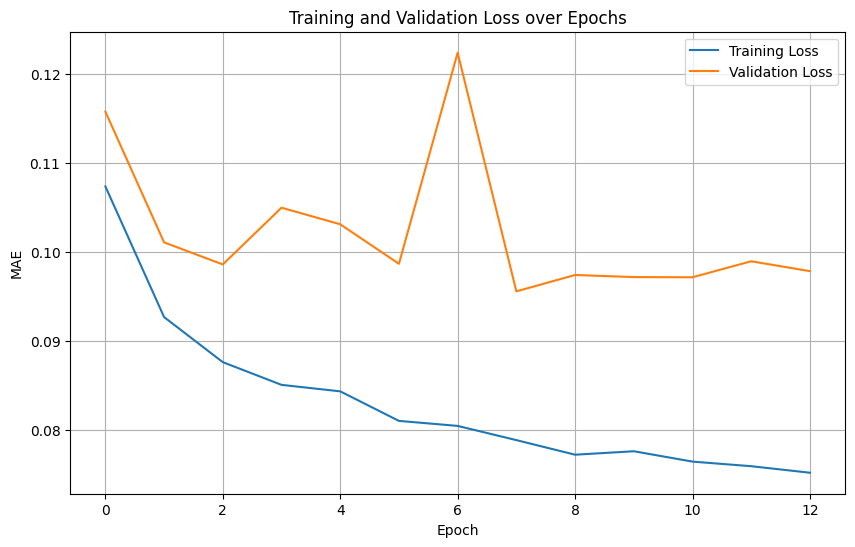

In [37]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_TFT.png')
plt.show()

In [38]:
# Inverse scaling for y_pred_train (predicted values on training set)
y_pred_train = model.predict(X_train)

# Only select the predicted target values (1st column for regression target)
y_pred_train_target = y_pred_train[:, 0]  

# Inverse scaling only on the target values (predicted power)
y_pred_train_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_train_target), len(numeric_columns) - 1)), y_pred_train_target]))[:, -1]  

# Inverse scaling for y_train (actual training set values)
train_inv = scaler.inverse_transform(train_scaled)
train_inv = pd.DataFrame(train_inv, columns=numeric_columns, index=train_scaled.index)
y_train_inv = train_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip initial `TIME_STEPS`

# Inverse scaling for y_val (actual values on validation set)
val_inv = scaler.inverse_transform(val_scaled)
val_inv = pd.DataFrame(val_inv, columns=numeric_columns, index=val_scaled.index)
y_val_inv = val_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Inverse scaling for y_pred_val (predicted values on validation set)
y_pred_val = model.predict(X_val)

# Only select the predicted target values
y_pred_val_target = y_pred_val[:, 0]  

# Inverse scaling only on the target values (predicted power)
y_pred_val_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_val_target), len(numeric_columns) - 1)), y_pred_val_target]))[:, -1]  # Extract the target column only

# Ensure that train_index and val_index are sliced properly for plotting
train_index = train_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_train_inv)]
val_index = val_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_val_inv)]

# Adjust y_train_inv and y_val_inv to match the sliced indices
y_train_inv = y_train_inv[:len(train_index)]
y_val_inv = y_val_inv[:len(val_index)]

# Adjust predicted values to match index lengths
y_pred_train_inv = y_pred_train_inv[:len(train_index)]
y_pred_val_inv = y_pred_val_inv[:len(val_index)]

98/98 [==============================] - 2s 22ms/step


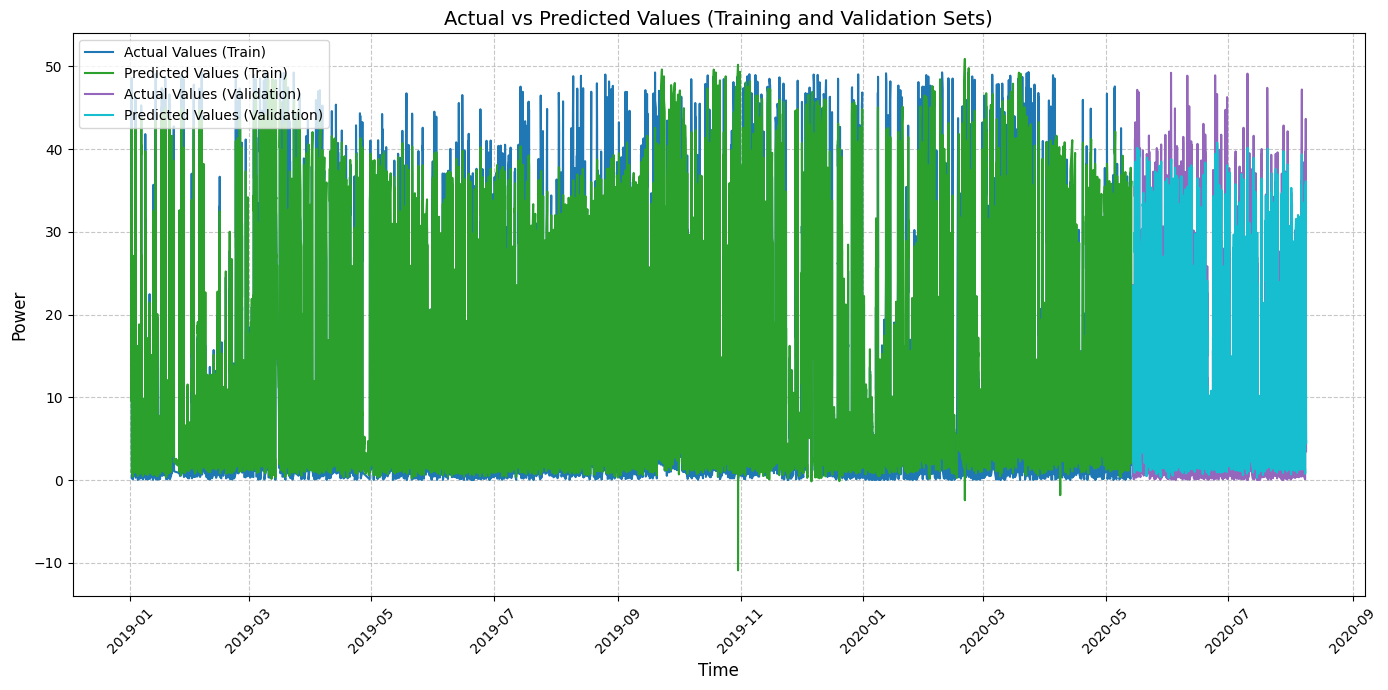

In [39]:
# Plot Actual vs Predicted Values for Training and Validation Sets
plt.figure(figsize=(14, 7))

# Updated color palette
train_actual_color = '#1f77b4'  
train_predicted_color = '#2ca02c'  
val_actual_color = '#9467bd'  
val_predicted_color = '#17becf' 

# Plot for Training Set
plt.plot(train_index, y_train_inv, label='Actual Values (Train)', color=train_actual_color)
plt.plot(train_index, y_pred_train_inv, label='Predicted Values (Train)', color=train_predicted_color)

# Plot for Validation Set
plt.plot(val_index, y_val_inv, label='Actual Values (Validation)', color=val_actual_color)
plt.plot(val_index, y_pred_val_inv, label='Predicted Values (Validation)', color=val_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Training and Validation Sets)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)

# Move the legend to the top-left corner
plt.legend(fontsize=10, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_ALTSM.png", dpi=300)

# Show the plot
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training Set Metrics
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
r2_train = r2_score(y_train_inv, y_pred_train_inv)

# Validation Set Metrics
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = np.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
r2_val = r2_score(y_val_inv, y_pred_val_inv)

# Print the Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²: {r2_val:.4f}")

Training Set Metrics:
MAE: 2.9427
RMSE: 4.9570
R²: 0.8367

Validation Set Metrics:
MAE: 3.4561
RMSE: 5.0384
R²: 0.7935


In [41]:
# Prediction on test set
y_pred = model.predict(X_test)

# Inverse scaling for y_test (actual values)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)

124/124 [==============================] - 3s 24ms/step


In [42]:
# Prediction on test set
y_pred = model.predict(X_test)

# Only select the predicted target values (1st column for regression target)
y_pred_test_target = y_pred[:, 0]  

# Inverse scaling for y_pred_test (predicted values on test set)
y_pred_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_test_target), len(numeric_columns) - 1)), y_pred_test_target]))[:, -1]  # Extract the target column only

# Inverse scaling for y_test (actual values on test set)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)
y_test_inv = test_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Align the test index
test_index = test_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_inv)]

# Ensure that y_test_inv and y_pred_inv have matching lengths for plotting
y_test_inv = y_test_inv[:len(test_index)]
y_pred_inv = y_pred_inv[:len(test_index)]


124/124 [==============================] - 3s 20ms/step


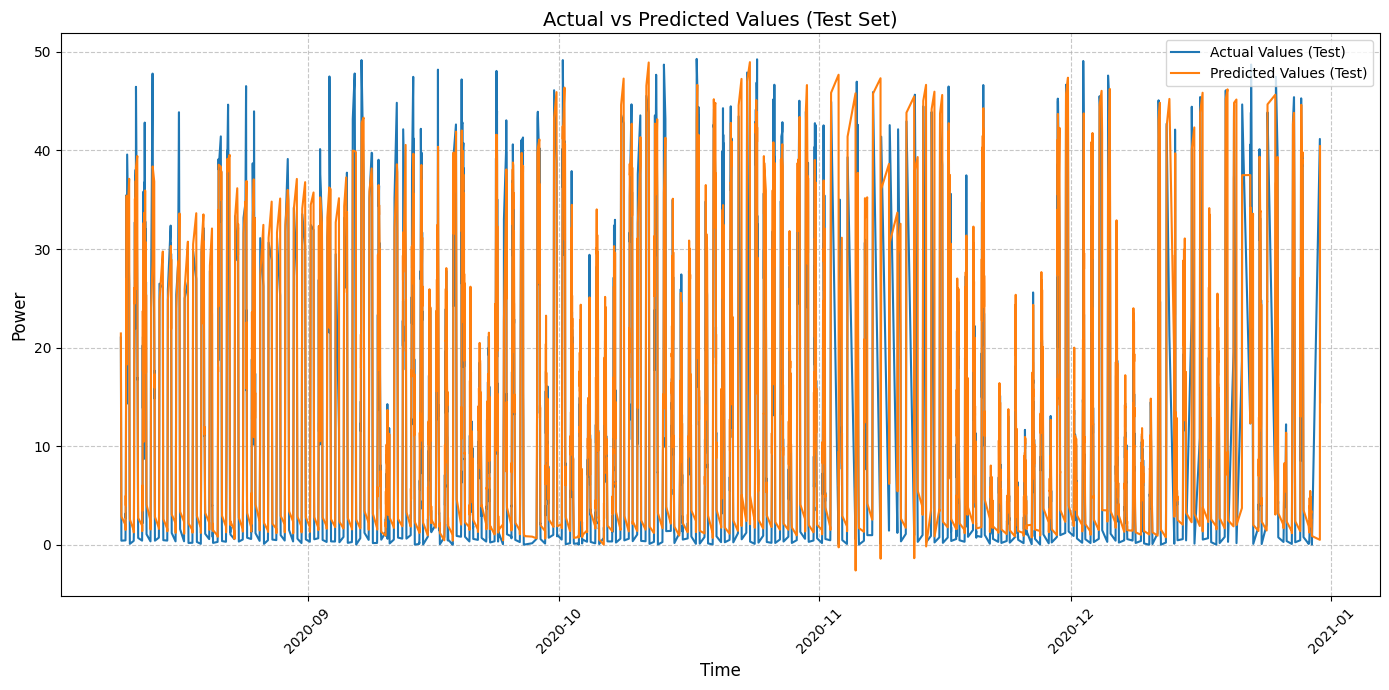

In [43]:
# Plot Actual vs Predicted Values for Test Set
plt.figure(figsize=(14, 7))

# Updated color palette with orange and blue
test_actual_color = '#1f77b4' 
test_predicted_color = '#ff7f0e' 

# Plot for Test Set
plt.plot(test_index, y_test_inv, label='Actual Values (Test)', color=test_actual_color)
plt.plot(test_index, y_pred_inv, label='Predicted Values (Test)', color=test_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_test_ALSTM.png", dpi=300)

# Show the plot
plt.show()


In [44]:
from datetime import datetime 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Save metrics to CSV
metrics = {
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}

metrics_df = pd.DataFrame([metrics])
metrics_file = 'TFT_metrics.csv'

if not os.path.isfile(metrics_file):
    metrics_df.to_csv(metrics_file, index=False)
else:
    metrics_df.to_csv(metrics_file, mode='a', header=False, index=False)

print(f"Metrics saved to {metrics_file}")


MAE: 3.79
RMSE: 6.02
R²: 0.7453
Metrics saved to LSTM_metrics.csv


In [45]:
model.save('TFT_model.h5')